# Tomsk team


# Load libraries

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, RobustScaler, KBinsDiscretizer
import warnings

warnings.filterwarnings("ignore")

#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/My Drive/Colab Notebooks/SPWLA/notebooks

path = os.getcwd()
path = path + "/../"

sys.path.append(path + "src/data/")
from load_data import get_config, get_data
from manipulate_data import transform_data, get_predictors_and_target

sys.path.append(path + "src/features/")
from build_features import mean_target_enc

sys.path.append(path + "src/models/")
from train_model import build_model
from prediction_correction import apply_heuristics

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/SPWLA/notebooks


# Train data loading

In [3]:
config = get_config()  # load config file
df = get_data()  # load train data
df = transform_data(df)  # prepare train dataset

features = config["model_settings"]["features"]  # get features for data preparation
target = config["model_settings"]["target"]  # get array with targets
group = config["model_settings"]["group"]  # get name of groups in the dataset

df[features] = df[features].fillna(0)

columns = np.append(features, target)

train.csv
Shape of the initial dataset: (318967, 17).
Shape after duplicates dropping: (318967, 17).
Shape of the processed dataset: (318967, 17).


# Train data preparation

In [4]:
df = df.dropna(subset=target)  # drop rows where target is NaN
df[features] = df[features].fillna(method="backfill")
n_bins = config["model_settings"][
    "n_bins"
]  # get number of bins for mean target encoding
df, est, mean_target_PHIF = mean_target_enc(
    df=df, n_bins=n_bins
)  # perform mean target encoding
features_second = np.append(
    features, "DEN_PHIF_bins_" + str(n_bins) + "_mean_encoded"
)  # add feature feature array

clf = IsolationForest(
    random_state=config["model_settings"]["seed"],
    contamination=0.02,
    n_jobs=-1,
    n_estimators=500,
)  # build classifier
clf.fit(df[columns])  # fit classifier
prediction = clf.predict(df[columns])  # make prediction
df = df[prediction == 1]  # drop outliers

df = df.dropna(subset=features_second)  # drop rows where features are NaN

In [5]:
# use all the data to train the model
X_train, y_train, _ = get_predictors_and_target(
    df=df, feature_names=features_second
)  # get dataframes with features and target

# features preprocessing
scaler_features_robust = RobustScaler(
    quantile_range=(
        config["model_settings"]["q_min"],
        config["model_settings"]["q_max"],
    )
)  # features scaler # 1
scaler_features_robust.fit(X_train)
X_train = scaler_features_robust.transform(X_train)

scaler_features_min_max = MinMaxScaler()  # features scaler # 2
scaler_features_min_max.fit(X_train)
X_train = scaler_features_min_max.transform(X_train)

# target preprocessing
scaler_target_min_max = MinMaxScaler()  # target scaler
scaler_target_min_max.fit(y_train[target])
y_train[target] = scaler_target_min_max.transform(y_train[target])
y_train = np.array(y_train)

input_shape = (None, X_train.shape[0], X_train.shape[1])  # input shape for the model

# EDA

In [6]:
df_val = get_data(train=False)  # load validation data
df_val = transform_data(df=df_val, clip=False)  # data preparation

test.csv
Shape of the initial dataset: (11275, 14).
Shape after duplicates dropping: (11275, 14).
Shape of the processed dataset: (11275, 14).


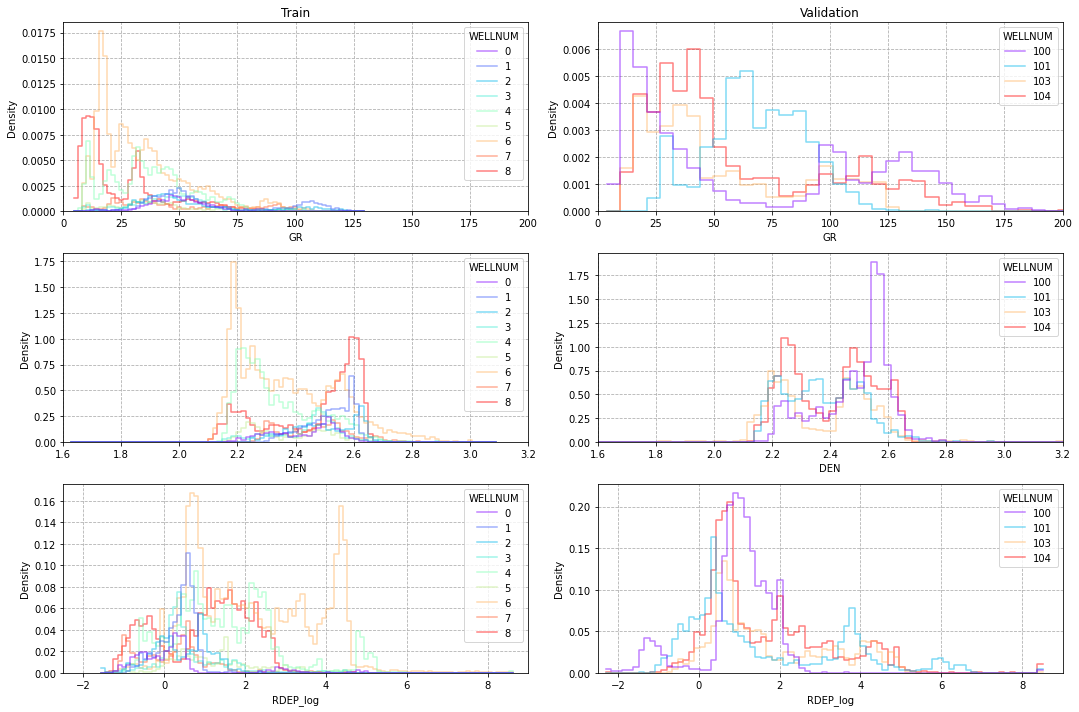

In [7]:
# plot histograms of features of  train and validation datasets
feature_columns = [["GR", "VSH"], ["DEN", "PHIF"], ["RDEP_log", "SW"]]

x_lims = [[0, 200], [1.6, 3.2], [-2.5, 9]]

palette = "rainbow"
alpha = 0.5
s = 10
stat = "density"
element = "step"

n_rows = 3
n_cols = 2

plt.figure(figsize=(15, 10))
for i, column in enumerate(feature_columns):

    if i == 0:
        j = i
    elif i == 1:
        j = 2
    else:
        j = 4

    plt.subplot(n_rows, n_cols, j + 1)
    if i == 0:
        plt.title("Train")
    sns.histplot(
        data=df,
        x=column[0],
        hue=group,
        palette=palette,
        alpha=alpha,
        fill=False,
        element=element,
        stat=stat,
    )
    plt.xlim(x_lims[i][0], x_lims[i][1])
    plt.grid(ls="--")

    plt.subplot(n_rows, n_cols, j + 2)
    if i == 0:
        plt.title("Validation")
    sns.histplot(
        data=df_val,
        x=column[0],
        hue=group,
        palette=palette,
        alpha=alpha,
        fill=False,
        element=element,
        stat=stat,
    )
    plt.xlim(x_lims[i][0], x_lims[i][1])
    plt.grid(ls="--")
plt.tight_layout()


- `DEN` in validation datset can have values up to 3.2. We assume that these intervals of `PHIF` are equal to 0.02 in validation datset. Please refer to the code below and the chart `DEN` vs `PHIF`

In [8]:
# get mean value of 'PHIF' where 'DEN' > 3
print("{:.2f}".format(df[df["DEN"] > 3][["PHIF"]].mean().values[0]))

0.02


In [9]:
# print 0.99 quantile and max values of `GR` feature
quantile = 0.99
print("Train {:.2f} quantile: {:.1f}".format(quantile, df["GR"].quantile(quantile)))
print("Train max value: {:.1f}".format(df["GR"].max()))
print(
    "Validation {:.2f} quantile: {:.1f}".format(
        quantile, df_val["GR"].quantile(quantile)
    )
)
print("Validation max value: {:.1f}".format(df_val["GR"].max()))

Train 0.99 quantile: 108.5
Train max value: 129.3
Validation 0.99 quantile: 231.6
Validation max value: 1711.4


- `GR` of valudation dataset can be much higher that in train datset. High `GR` values usually associated with high clay content, so we assumed that intervals with `GR` > max value of `GR` in train dataset would have `VSH` equal to 1. Please refer to the code below and the chart `GR` vs `VSH`

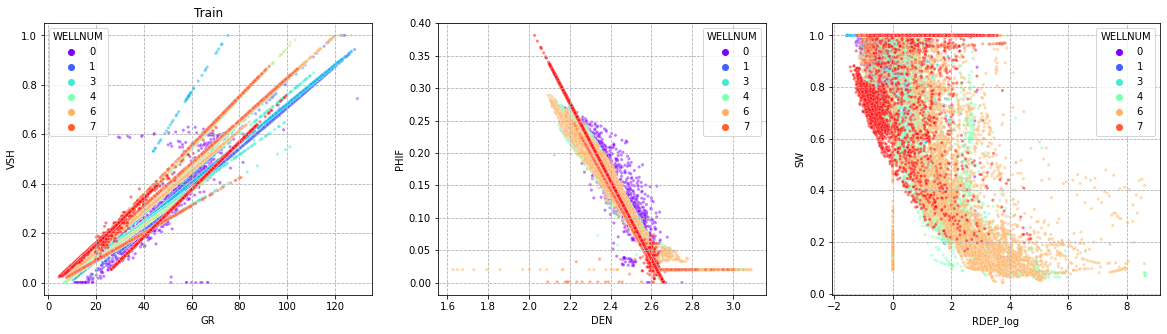

In [10]:
# plot scatterplots of target and features
n_rows = 1
n_cols = 3

plt.figure(figsize=(20, 5))
for i, column in enumerate(feature_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    if i == 0:
        plt.title("Train")
    sns.scatterplot(
        data=df, x=column[0], y=column[1], hue=group, palette=palette, alpha=alpha, s=s
    )
    plt.grid(ls="--")

- `RDEP_log` values of validation datset can reach values less that -2 and form the chart `RDEP_log` vs `SW` below it is clear that low values of `RDEP_log`  indicate high values of `SW`. So, we assumed that `SW` intervals with `RDEP_log` < -2 are equal to 1. Please refer to the chart below where it is shown that thete is high portion of samples in the train datset where `SW` equal to 1

,WELLNUM,RDEP_sqrt_mean,SW_mean
0,0,1.464037,0.871685
1,1,1.217702,0.988566
2,2,1.309012,0.960532
3,3,1.587300,0.828949
4,4,2.945692,0.490172
5,5,2.344602,0.554085
6,6,4.272176,0.454955
7,7,1.233676,0.965178
8,8,1.922130,0.903097


,WELLNUM,RDEP_sqrt_mean
0,100,1.898898
1,101,3.947012
2,103,3.359729
3,104,3.324303


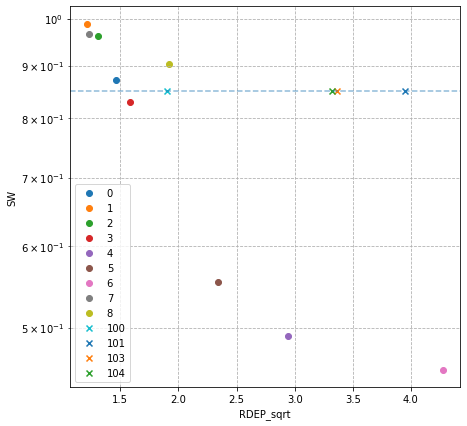

In [11]:
# plot scatterplot mean values of `RDEP_log` and `SW`
stats = ["mean"]
x = "RDEP_sqrt"
y = "SW"
stat_df = df.groupby([group]).agg({x: stats, y: stats,})
stat_df.columns = ["_".join(x) for x in stat_df.columns.ravel()]
stat_df = stat_df.reset_index(drop=False)
display(stat_df)

df_val

stat_df_val = df_val.groupby([group]).agg({x: stats})
stat_df_val.columns = ["_".join(x) for x in stat_df_val.columns.ravel()]
stat_df_val = stat_df_val.reset_index(drop=False)
display(stat_df_val)

plt.figure(figsize=(7, 7))

for i in stat_df[group].unique():
    plt.scatter(
        x=stat_df[stat_df[group] == i]["RDEP_sqrt_mean"],
        y=stat_df[stat_df[group] == i]["SW_mean"],
        label=i,
    )

sw_mean = 0.85
for i in stat_df_val[group].unique():
    plt.scatter(
        x=stat_df_val[stat_df_val[group] == i]["RDEP_sqrt_mean"],
        y=sw_mean,
        label=i,
        marker="x",
    )

plt.axhline(y=sw_mean, ls="--", alpha=alpha)

plt.xlabel(x)
plt.ylabel(y)
plt.yscale("log")
plt.grid(ls="--", which="both")
plt.legend()

- Wells with low `RDEP_sqrt` mean values tend to have higher mean `SW` values,  so we assumed that all interval of 100 well is equal to 1 as it lies near the wells which have high `SW` values

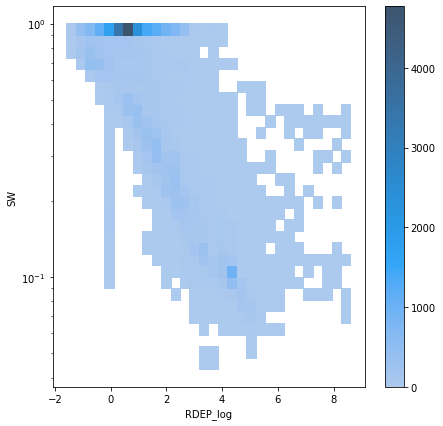

In [12]:
# plot 2D hist in order to show that
# most of the samples with low `RDEP_log` valus tend to have `SW` equal to 1
plt.figure(figsize=(7, 7))
sns.histplot(df, x="RDEP_log", y="SW", log_scale=(False, True), cbar=True, bins=30)

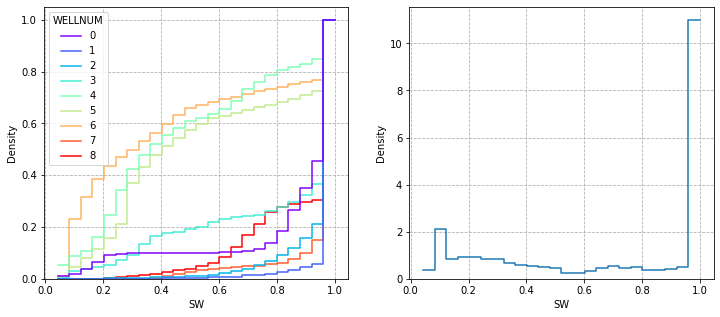

In [13]:
# plot histograms of `SW` target
n_rows = 1
n_cols = 2

plt.figure(figsize=(12, 5))

plt.subplot(n_rows, n_cols, 1)
sns.histplot(
    data=df,
    x="SW",
    hue=group,
    element="step",
    fill=False,
    cumulative=True,
    stat="density",
    common_norm=False,
    palette=palette,
)
plt.grid(ls="--")

plt.subplot(n_rows, n_cols, 2)
sns.histplot(
    data=df, x="SW", element="step", fill=False, cumulative=False, stat="density"
)
plt.grid(ls="--")

- High portion of samples in train dataset have `SW` equal to 1

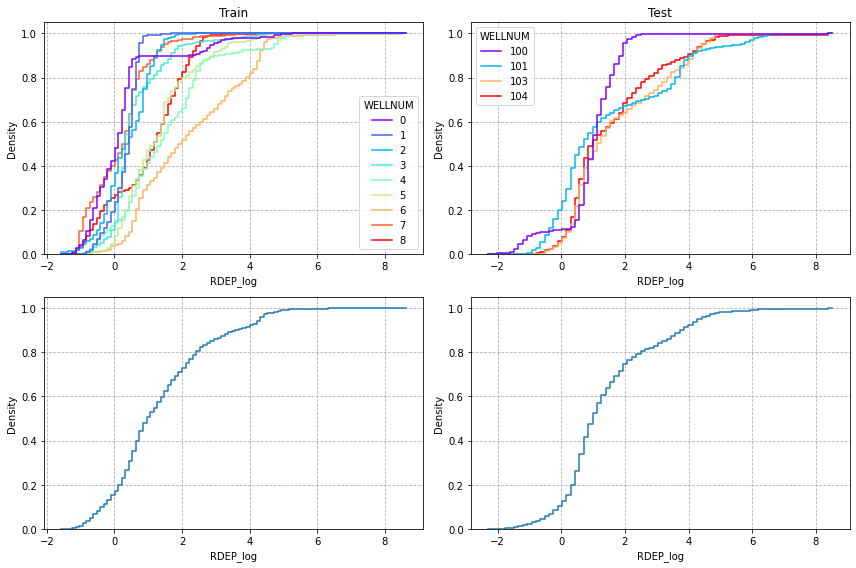

In [14]:
# plot histograms of `RDEP_log` feature
n_rows = 2
n_cols = 2

x = "RDEP_log"

plt.figure(figsize=(12, 8))

plt.subplot(n_rows, n_cols, 1)
plt.title("Train")
sns.histplot(
    data=df,
    x=x,
    hue=group,
    element="step",
    fill=False,
    cumulative=True,
    stat="density",
    common_norm=False,
    palette=palette,
)
plt.grid(ls="--")

plt.subplot(n_rows, n_cols, 2)
plt.title("Test")
sns.histplot(
    data=df_val,
    x=x,
    hue=group,
    element="step",
    fill=False,
    cumulative=True,
    stat="density",
    common_norm=False,
    palette=palette,
)
plt.grid(ls="--")

plt.subplot(n_rows, n_cols, 3)
sns.histplot(data=df, x=x, element="step", fill=False, cumulative=True, stat="density")
plt.grid(ls="--")

plt.subplot(n_rows, n_cols, 4)
sns.histplot(
    data=df_val, x=x, element="step", fill=False, cumulative=True, stat="density"
)
plt.grid(ls="--")

plt.tight_layout()

- Well 100 tend to have low `RDEP_log` values. Low `RDEP_log` values is a strong indicator of high `SW` values. Please refer to the chart below

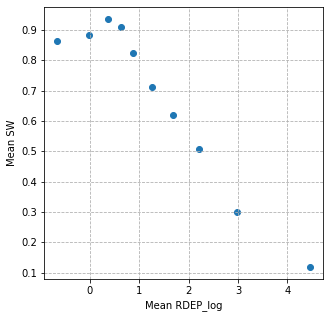

In [15]:
# plot scatterplot of mean values of `RDEP_log` and `SW`
def plot_chart(df):
    column_to_transform = ["RDEP_log"]
    est = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="quantile")
    est.fit(df[column_to_transform])
    data = est.transform(df[column_to_transform])
    data = pd.DataFrame(data, columns=column_to_transform)
    data = data.add_suffix("_bins_" + str(n_bins))
    data.index = df.index
    df = df.join([data])
    column = column_to_transform[0] + "_bins_" + str(n_bins)

    plt.figure(figsize=(5, 5))
    x = "RDEP_log"
    y = "SW"

    plt.scatter(df.groupby(column)[x].mean(), df.groupby(column)[y].mean())
    plt.grid(ls="--")
    plt.xlabel("Mean " + x)
    plt.ylabel("Mean " + y)


plot_chart(df=df)

# Model building

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 41462, 2048  12288     
                             )                                   
                                                                 
 dropout (Dropout)           (None, None, 41462, 2048  0         
                             )                                   
                                                                 
 dense_1 (Dense)             (None, None, 41462, 512)  1049088   
                                                                 
 dropout_1 (Dropout)         (None, None, 41462, 512)  0         
                                                                 
 dense_2 (Dense)             (None, None, 41462, 3)    1539      
                                                                 
Total params: 1,062,915
Trainable params: 1,062,915
Non-

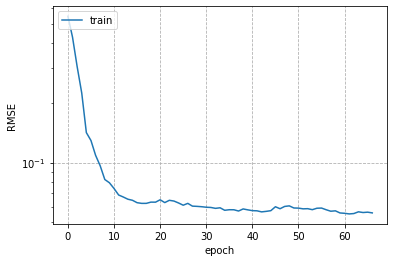

In [16]:
model = build_model(
    X_train=X_train, y_train=y_train, input_shape=input_shape
)  # build model

# Evaluate data for post-prediction correction

In [17]:
# get data for post-prediction correction
prediction = model.predict(X_train)  # get prediction on train data
prediction = scaler_target_min_max.inverse_transform(
    prediction
)  # apply target inverse transformation
prediction = pd.DataFrame(
    prediction, columns=[element + "_pred" for element in target]
)  # create dataframe with prediction
df_error = df.reset_index(drop=True).join(
    [prediction]
)  # add prediction to train dataset
df_error["SW_error"] = df_error["SW"] - df_error["SW_pred"]  # calculate error
statistics = df_error.agg({"SW_error": ["mean"]})  # get mean error values
statistics

,SW_error
mean,0.012068


# Loading test data and prediction making

In [18]:
df_val = get_data(train=False)  # load validation data
df_val = transform_data(df=df_val, clip=False)  # perform data preparation
df_val[features] = df_val[features].fillna(0)  # fill NaN
df_val, _, _ = mean_target_enc(
    df=df_val, est=est, mean_target_PHIF=mean_target_PHIF, n_bins=n_bins
)  # peform mean target encoding
df_val[features_second] = df_val[features_second].fillna(method="backfill")
val = scaler_features_robust.transform(
    df_val[features_second]
)  # apply features scaler # 1
val = scaler_features_min_max.transform(val)  # apply features scaler # 2

test.csv
Shape of the initial dataset: (11275, 14).
Shape after duplicates dropping: (11275, 14).
Shape of the processed dataset: (11275, 14).


In [19]:
prediction = model.predict(val)  # get prediction on validation data
prediction = scaler_target_min_max.inverse_transform(
    prediction
)  # apply target inverse tranformation
prediction = pd.DataFrame(
    prediction, columns=target
)  # get dataframe with prediction on validation data
prediction = apply_heuristics(
    prediction=prediction, df_val=df_val, df=df, statistics=statistics
)  # apply post-prediction data correction
prediction = prediction.clip(0, 1)  # make the target lie in the range [0:1]

In [20]:
prediction.to_csv(
    config["model_settings"]["path_to_data"] + "submission.csv", index=False
)  # save prediction